# RedGrease Demo at RedisConf 2021

Quick demonstration of how to create and run Redis Gears functions, using RedGrease.

## [Demos](#Demos):
1. [The Basics](#1.-The-Basics)
2. [Complex Query](#2.-Complex-Query)
3. [Transaction Stream Processing](#3.-Transaction-Stream-Processing)
4. [Custom Command](#4.-Custom-Command)


# Preparations
Before running the demos, make sure that the prerequisites are met and that the preparation steps have successfully been executed. 
Some preparation steps, particularly the downloads, may take quite some time. 

## 1. Prerequisites
- Python3.7
- Pip
- Docker
- Jupyter

Run the cell below tho validate your prerequisites.

In [ ]:
# Run cell to test your environment requirements

import sys
import re
pyver = !{sys.executable} --version  # type: ignore 
pipver = !{sys.executable} -m pip --version  # type: ignore
dockver = !docker --version  # type: ignore

if not re.match("Python 3.7", pyver[0]):
    raise SystemExit(f"This demo only supports Python 3.7. You are running {pyver[0]}.")

if not re.match(".*\(python 3.7\)", pipver[0]):
    raise SystemExit("Please install Pip for yout Python 3.7 environment.")

if not re.match("Docker version", dockver[0]):
    raise SystemExit("Please install Docker")

print("Requirements all look good!")

## 2. Python Requirements

Install the Python packages required for the demo:

- `redgrease[client]` - The RedGrease client library for Redis Gears. This is what is being demonstrated.

- `ipywidgets` - Jupyter notebook exetension, for displaying widgets, e.g. buttons, in this notebook.
- `requests` - For downloading content.

Run the cell below to install the requirements.

In [ ]:
%%capture reqs_install_output
!{sys.executable} -m pip install redgrease[client] ipywidgets requests
!jupyter nbextension enable --py widgetsnbextension

## 3. Download Datasets
Some of the demos requiere a portion of the [COCO Dataset](https://cocodataset.org) to be uploaded into the Redis Gears Cluster.
The COCO Dataset (Common Objects in Context) is a fairly large set of (~247,000) images and corresponding annotations of what tey are depicting.

### Example:
<img src="coco_example.jpg" > [COCO Example](coco_example.jpg)

```
a man riding a snowboard down a ski slope.
a snowboarder sailing down a snowy hillside on a mountain.
a man is snowboarding past blue markers on a mountain.
a man on a snowboard in the snow.
a man snow boarding in the snow on a slope. 
```


For the demo we will only pre-download the annotations (json), not the images (jpeg), but it is still between 250 - 500 MB of data, depending on which portions you choose.

There are two annotation packages to choose from. 
- **COCO Train/Cal 2014** - Annotations for 124,000 images (241 MB)
- **COCO Train/Val 2017** - Annotations for 123,000 images (241 MB)

Either or both may be used. 
Run the cell below and select using the buttons which dataset(s) to download.

In [ ]:
# This code is just for preparation of the demo.
# It is NOT part of the demo itself
#
# Download COCO Annotations 
# Run the cell, then:
# - Validate or modify the Download directory
# - Click the button, or buttons for the annotations to download

import ipywidgets as widgets
import os
import requests

coco_annotations_url = "http://images.cocodataset.org/annotations"
annotations_file_pattern = "annotations_trainval{}.zip"

layout = widgets.Layout(width="30%")
output = widgets.Output()

def get_download_path():
    download_dir = "."
    if os.name == 'nt':
        import winreg
        sub_key = r'SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\Shell Folders'
        downloads_guid = '{374DE290-123F-4565-9164-39C4925E467B}'
        with winreg.OpenKey(winreg.HKEY_CURRENT_USER, sub_key) as key:
            download_dir = winreg.QueryValueEx(key, downloads_guid)[0]
    else:
        download_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

    return os.path.join(download_dir, "COCO")

download_location = widgets.Text(
    value=get_download_path(),
    placeholder="Download directory",
    description="Directory to download annotations to.",
    layout=layout,
)
display(download_location)

def dl_state(button, downloading=None):
    year = button.value
    annotations_file_name = annotations_file_pattern.format(year)
    destination = os.path.join(download_location.value, annotations_file_name)
    is_downloaded = os.path.isfile(destination)
    button.disabled = is_downloaded or downloading is not None
    if downloading:
        button.description=f"Downloading COCO {year} annotations (241 MB): {downloading}%. Please wait!"
    elif is_downloaded:
        button.description=f"Congrats! COCO {year} annotataions is downloaded!"
    else:
        button.description=f"Download COCO {year} annotations (241 MB)"
    return is_downloaded, annotations_file_name, destination


def download_button_pressed(btn):
    downloaded, file_name, destination = dl_state(btn)
    if downloaded:
        return
    if not os.path.isdir(download_location.value):
        os.mkdir(download_location.value)
    try:
        response = requests.get(
            f"{coco_annotations_url}/{file_name}",
            stream=True
        )
        total_length = response.headers.get('content-length')
        with open(destination, "wb") as f:
            if total_length is None: # no content length header
                dl_state(btn, "???")
                f.write(response.content)
                return
            total_length = int(total_length)
            dl = 0
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                dl_state(btn, int(100*(dl/total_length)))

    except Exception:
        try:
            os.remove(destination)
        except Exception:
            pass
    finally:
        dl_state(btn)

for year in ["2014", "2017"]:
    download_button = widgets.Button(
        tooltip='Start download of selected datasets into the selected download directory.',
        layout=layout
    )
    download_button.value = year
    dl_state(download_button)
    download_button.on_click(download_button_pressed)
    display(download_button)

display(output)

## 4. Download and run Redis Gears Cluster Docker image
Run the cell below to download a Redis Gears Cluster Docker image (~605 MB), if not already present, and run it. 

In [ ]:
redis_gears_cluster_image = "redislabs/rgcluster:1.0.6"
redis_gears_cluster_container_name = "demo_gears_cluster"

redis_gears_single_image = "redislabs/redisgears:1.0.6"
redis_gears_single_container_name = "demo_gears_single"

# Get the correct Redis Gears Images
!docker pull {redis_gears_single_image}
!docker pull {redis_gears_cluster_image}

# Check if the single container is already running.
container_info = !docker container inspect {redis_gears_single_container_name}
if container_info[0] == "[]":
    print("Starting Redis Gears single instance")
    !docker run --name {redis_gears_single_container_name} --rm -d -p 6379:6379 {redis_gears_single_image}


# Check if the cluster container is already running.
container_info = !docker container inspect {redis_gears_cluster_container_name}
if container_info[0] == "[]":
    print("Starting Redis Gears cluster instance")
    !docker run --name {redis_gears_cluster_container_name} --rm -d -p 30001:30001 -p 30002:30002 -p 30003:30003 {redis_gears_cluster_image}

print("Redis Gears containers are running!")

## 5. Load Annotation Data into Redis cluster
By running the cell below, the COCO annotations downloaded above will be loaded into the Redis Cluster.

In [ ]:
import glob
import itertools
import json
import os
import re
import redgrease
import zipfile

annotation_archive_files = os.path.join(download_location.value, "annotations_trainval*.zip")
annotation_archives = glob.glob(annotation_archive_files)

if not annotation_archives:
    print("no archives")
    raise SystemExit("Please download either or both COCO annotations as per instructions above.")

r = redgrease.RedisGears(host="localhost", port=30001)

annotation_json_pattern = re.compile("annotations/(\w+)_([a-zA-Z]+)([0-9]+).json")

annotation_types = ["instances", "person_keypoints", "captions"]
years = ["2014", "2017"]
purpose = ["val", "train"]

output = widgets.Output()
progress = widgets.Text("", layout=layout)

def load_annotation_info(base_key, info):
    annotation_info_key = f"{base_key}/info"
    r.hset(annotation_info_key, mapping=info)
    return annotation_info_key

def load_license_info(base_key, license):
    license_key = f"{base_key}/license/{license['id']}"
    if not r.exists(license_key):
        r.hset(license_key, mapping=license)
    return license_key

def load_image_info(base_key, image_info):
    img_info_key = f"{base_key}/image/{image_info['id']}/info"
    if not r.exists(img_info_key):
        r.hset(img_info_key, mapping=image_info)
    return img_info_key

def load_keypoint_names(base_key, keypoints):
    keypoints_key = f"{base_key}/keypoints"
    r.lpush(keypoints_key, *keypoints)
    return keypoints_key

def load_list_of_str(base_key, sequence):
    list_key = f"{base_key}/skeleton"
    r.lpush(list_key, *map(str, sequence))
    return list_key

def load_category(base_key, category):
    category_key = f"{base_key}/category/{category['id']}"

    if "keypoints" in category:
        category["keypoints"] = load_keypoint_names(category_key, category["keypoints"])
    if "skeleton" in category:
        category["skeleton"] = load_list_of_str(category_key, category["skeleton"])

    r.hset(category_key, mapping=category)
    return category_key

def load_segmentation(base_key, segmentation):
    segmentation_key = f"{base_key}/segmentation"
    if not r.exists(segmentation_key):
        for i, segment in enumerate(segmentation):
            segment_key = f"{segmentation_key}/{i}"
            r.lpush(segment_key, *segment)
            r.rpush(segmentation_key, segment_key)
    return segmentation_key

def load_annotation(base_key, annotation):
    
    annotation_key = f"{base_key}/image/{annotation['image_id']}/annotation/{annotation['id']}"
    
    if not r.exists(annotation_key):
        if "segmentation" in annotation:
            # Replace the 'segmentation' list-of-lists, with a key with a list of keys, that in turn point to the inner lists :)
            annotation["segmentation"] = load_segmentation(annotation_key, annotation["segmentation"])
        
        if "bbox" in annotation:
            # Replace the 'bbox' with a string reepresentaton.load_segmentation
            annotation["bbox"] = str(annotation["bbox"])

        if "keypoints" in annotation:
            annotation["keypoints"] = load_list_of_str(annotation_key, annotation["keypoints"])

        r.hset(annotation_key, mapping=annotation)
    return annotation_key

def load_annotation_jsons_from_zip(zip_file):
    with zipfile.ZipFile(zip_file) as archive:
        for file_name in archive.namelist():
            is_annotation_file = annotation_json_pattern.match(file_name)
            if not is_annotation_file:
                continue
            
            annotation_type = is_annotation_file.group(1)
            dataset_purpose = is_annotation_file.group(2)
            dataset_year = is_annotation_file.group(3)

            if not annotation_type in annotation_types:
                continue
            
            if not dataset_purpose in purpose:
                continue
                
            if not dataset_year in years:
                continue

            with archive.open(file_name) as json_file:
                contents = json.load(json_file)
    
            base_key = f"/dataset/coco/{dataset_year}"
            info_key = f"{base_key}/general/{annotation_type}/{dataset_purpose}"
                
            # info
            if "info" in contents:
                progress.value = f"Loading info for {dataset_purpose} {dataset_year} {annotation_type}"
                load_annotation_info(info_key, contents["info"])

            # licenses
            if "licenses" in contents:
                progress.value = f"Loading licenses for {dataset_purpose} {dataset_year} {annotation_type}"
                for lic in contents["licenses"]:
                    load_license_info(info_key, lic)
                    
            # images
            if "images" in contents:
                progress.value = f"Loading images for {dataset_purpose} {dataset_year} {annotation_type}"
                for image_info in contents["images"]:
                    load_image_info(base_key, image_info)

            # annotations
            if "annotations" in contents:
                progress.value = f"Loading annotations for {dataset_purpose} {dataset_year} {annotation_type}"
                for annotation in contents["annotations"]:
                    load_annotation(base_key, annotation)

            # categories (for "instances" and "person_keypoints")
            if "categories" in contents:
                progress.value = f"Loading categories for {dataset_purpose} {dataset_year} {annotation_type}"
                for category in contents["categories"]:
                    load_category(base_key, category)

            
display(progress)
for archive in annotation_archives:
    progress.value = f"Unzipping {archive}"
    load_annotation_jsons_from_zip(archive)
progress.value = "Done!"


# Demos
This is the actual Demo section. Everything above is just preparations.

1. [The Basics](#1.-The-Basics)
2. [Complex Query](#2.-Complex-Query)
3. [Transaction Stream Processing](#3.-Transaction-Stream-Processing)
4. [Custom Command](#4.-Custom-Command)


<a id="demm-basics"></a>
## 1. The Basics
Showcasing some of the basic features and commands of the redgrease package.

Instantiation of client / connection to Redis Gears engines

In [ ]:
import redgrease
import redgrease.utils
from IPython.display import Image
from IPython.core.display import HTML 

# Create connection / client for single instance Redis
single = redgrease.RedisGears() 

# Create connectoin / client for Redis Cluster 
cluster = redgrease.RedisGears(
    startup_nodes=[
        {"host":"localhost", "port":30001},
        {"host":"localhost", "port":30002},
        {"host":"localhost", "port":30003},
    ]
)


Redis v6 commands are accessible

In [ ]:
a = single.flushall()
b = single.set("Foo", 21)
c = single.hset("Bar", mapping={"spam":"eggs", "meaning":8})
d = single.hincrby("Bar", "meaning", 34)
e = single.xadd("tlogs::0", {"msg":"START", "from":0, "to":0, "amount":0})

a, b, c, d, e

Gears-specific commands can be accessed through the `gears` property.

Examples:

In [ ]:
cluster_pystats = cluster.gears.pystats()

print(f"Cluster Redis - Python Stats:\n{cluster_pystats}\n")

In [ ]:
cluster_info = cluster.gears.infocluster()

print(f"Cluster Redis - Cluster Info:\n{cluster_info}\n")

In [ ]:
cluster_refreshed = cluster.gears.refreshcluster()

print(f"Cluster Redis - Cluster Refresh Response:\n{cluster_refreshed}\n")

In [ ]:
single_pystats = single.gears.pystats()

print(f"Single-node Redis - Python Stats:\n{single_pystats}\n")

Gear functions can be invoked as strings

In [ ]:
# Iterate through all Redis key-value records, and return all record data.
all_records_gear = single.gears.pyexecute("GearsBuilder().run()")

print("Single-node Redis - All-records gear: [")
for result in all_records_gear:
    print(f"  {result}")
print("]\n")

In [ ]:
# Iterate through all Redis key-value records, and return just the key and type
key_type_gear = single.gears.pyexecute("GearsBuilder().map(lambda record:(record['key'], record['type'])).run()")

print("Single-node Redis - Key-types gear: [")
for result in key_type_gear:
    print(f"  {result}")
print("]\n")

In [ ]:
# Count the total number of keys / records
single_record_count = single.gears.pyexecute("GearsBuilder().count().run()")

print(f"Single-node Redis - Record count: {single_record_count}")

### GearFunction objects
RedGrease allows for cunstruction of GearFuntion objects instread of function strings.

In [ ]:
record_count = redgrease.KeysOnlyReader().count().run()

cluster_record_count = cluster.gears.pyexecute(record_count)

print(f"Cluster Redis - Total records: {cluster_record_count}")

Partial RedGrease GearFunction objects can be composed and reused

In [ ]:
images = redgrease.KeysReader("/dataset/coco/*/image/*/info").map(lambda record: record['value'])

image_count = images.count()

square_images = images.filter(lambda img: img['height'] == img['width'])

some_image_urls = square_images.collect().limit(4).map(lambda record: record['coco_url'])


type(images), type(image_count), type(square_images), type(some_image_urls)


You can dynamically create parameterized partial RedGrease GearFunctions in normal functions

In [ ]:
def instance_annotations(year="*"):
    return (
        redgrease.KeysReader(f"/dataset/coco/{year}/image/*/annotation/*")
        .filter(lambda record: record['type'] == "hash")
        .map(lambda record: record["value"])
    )

Gears Functions can be exectuted in a number of different ways

In [ ]:
# The "textbook" way
img_cnt = cluster.gears.pyexecute(image_count.run())

print(f"Total number of images: {img_cnt}\n")

In [ ]:
# As a partial function, i.e. without a closing 'run' or 'register' (Run is inferred)
annotation_cnt = cluster.gears.pyexecute(instance_annotations().count())

print(f"Total number of annotations: {annotation_cnt}\n")

In [ ]:
# Directly from a closed GearFunction, using the `on`-method
avg_square_size = square_images.map(lambda sq: sq['width']).avg().run()

print(f"Look, it aint no PartialGearFunction no more. it is a {type(avg_square_size)}")
avg_square_size.on(cluster)

In [ ]:
# Directly in the closing `run` or `register` operation, using the `on` argument
img_urls = some_image_urls.run(on=cluster)

print(f"Some square images")
for img_url in img_urls:
    display(Image(url=img_url))

<a id="demo-query"></a>
## 2. Complex Query 

Let's construct a query GearFunction that can take a number of annotation category names and for each an optional min and max count, 
and then finds images that fit those constraint.

Firstly, notice how annotations are stored

In [108]:
a1 = cluster.hgetall("/dataset/coco/2017/image/22222/annotation/2027787")
a2 = cluster.hgetall("/dataset/coco/2017/image/22222/annotation/1727529")
a1, a2

({b'segmentation': b'/dataset/coco/2017/image/22222/annotation/2027787/segmentation',
  b'area': b'160.06269999999992',
  b'iscrowd': b'0',
  b'image_id': b'22222',
  b'bbox': b'[57.33, 86.94, 15.06, 16.69]',
  b'category_id': b'1',
  b'id': b'2027787'},
 {b'segmentation': b'/dataset/coco/2017/image/22222/annotation/1727529/segmentation',
  b'area': b'2565.190249999999',
  b'iscrowd': b'0',
  b'image_id': b'22222',
  b'bbox': b'[519.53, 83.45, 42.88, 118.36]',
  b'category_id': b'1',
  b'id': b'1727529'})

Lets create some lookup tables for the annotation categories and their IDs

In [109]:
# Merging dicttionaries
def dict_merge(d1, d2):
    return {**d1, **d2}

# Lookup from category name to category id
category_id_lookup = (
    redgrease.KeysReader("/dataset/*/category/*")
    .filter(lambda record: record['type'] == 'hash')
    .map(lambda record: {record['value']['name']:record['value']['id']})
    .aggregate({},dict_merge, dict_merge)
    .run(on=cluster)
)

category_name_lookup = {cat_id:cat_name for cat_name, cat_id in category_id_lookup.items() }

print(f"Number of categories: {len(category_id_lookup)}")
print(f"Errors: {category_id_lookup.errors}")
print()
print(f"Lookup id by name:\n{category_id_lookup}")

Number of categories: 80
Errors: []

Lookup id by name:
{'wine glass': '46', 'fire hydrant': '11', 'dog': '18', 'train': '7', 'spoon': '50', 'tie': '32', 'parking meter': '14', 'car': '3', 'tv': '72', 'hot dog': '58', 'bench': '15', 'cake': '61', 'bus': '6', 'cup': '47', 'cow': '21', 'toothbrush': '90', 'keyboard': '76', 'snowboard': '36', 'sheep': '20', 'bicycle': '2', 'scissors': '87', 'tennis racket': '43', 'traffic light': '10', 'giraffe': '25', 'bowl': '51', 'pizza': '59', 'cell phone': '77', 'horse': '19', 'zebra': '24', 'orange': '55', 'surfboard': '42', 'laptop': '73', 'sandwich': '54', 'refrigerator': '82', 'vase': '86', 'bed': '65', 'sports ball': '37', 'skateboard': '41', 'umbrella': '28', 'donut': '60', 'dining table': '67', 'suitcase': '33', 'microwave': '78', 'potted plant': '64', 'hair drier': '89', 'airplane': '5', 'boat': '9', 'knife': '49', 'broccoli': '56', 'bird': '16', 'person': '1', 'couch': '63', 'kite': '38', 'bear': '23', 'sink': '81', 'frisbee': '34', 'toilet'

Collect the number of annotations of each category per image

In [110]:
# for each annotation we add one the accumulator for the image, under the category of the annotation
def accumulate_categories(image_id, accumulator, annotation):
    if 'category_id' in annotation:
        annotation_category_id = annotation['category_id']
        accumulator[annotation_category_id] = accumulator.get(annotation_category_id, 0) + 1
        return accumulator

    
# add the previousls accumlated counts from eace shard to a global ccumulator for the image
def accumulate_category_counts(image_id, accumulator, category_count):
    for category, count in category_count.items():
        accumulator[category] = accumulator.get(category, 0) + count
    return accumulator


# Just renaming fields so it's clearer what they contain
def format_img_stats(img_stats):
    return {
        'image_id': img_stats['key'],
        'instances': img_stats['value']
    }


# GearFunction that counts the number of annotations of each category in each image
category_count_by_image = instance_annotations(2017).aggregateby(
    extractor = lambda annotation : annotation.get('image_id', -1),  # Group the annotatioms by image_id
    zero = {},  # For each group we use a dict to accumulate the counts of each category of annotaion
    seqOp = accumulate_categories,  # Accumulate/reduce the category counts locally on each shard
    combOp = accumulate_category_counts  # Accumulate/reduce the local results globally
).map(format_img_stats)



# Run the GearFunction, but limit to 10 results per shard (for sanity)
c = category_count_by_image.limit(10).run(on=cluster)

In [114]:
print(f"Number of results: {len(c)}")
print(f"Errors: {c.errors}")
print()
for img in c:
    instances = { category_name_lookup.get(cat_id, cat_id):count for cat_id, count in img['instances'].items() }
    print(f"Image #{img['image_id']} instances: {instances}")
print("...")
print("and so on")

Number of results: 30
Errors: []

Image #483381 instances: {'teddy bear': 1, 'person': 1, 'chair': 1}
Image #237137 instances: {'person': 2, 'cake': 8}
Image #17267 instances: {'car': 3, 'traffic light': 2, 'person': 3, 'handbag': 1, 'truck': 1, 'bicycle': 2}
Image #197756 instances: {'cell phone': 2, 'bottle': 1, 'person': 3}
Image #451278 instances: {'bed': 2, 'teddy bear': 1, 'chair': 2, 'person': 1}
Image #422878 instances: {'person': 2, 'knife': 1, 'horse': 1}
Image #193332 instances: {'cake': 1, 'broccoli': 1, 'person': 2, 'knife': 1, 'dining table': 1, 'tie': 1}
Image #475564 instances: {'orange': 1}
Image #247368 instances: {'zebra': 2, 'bird': 1}
Image #543468 instances: {'vase': 1}
Image #131174 instances: {'person': 2, 'airplane': 1}
Image #361316 instances: {'spoon': 1, 'fork': 1, 'person': 1, 'wine glass': 2, 'sandwich': 2, 'dining table': 1}
Image #253219 instances: {'book': 12, 'cat': 1, 'tv': 1}
Image #575461 instances: {'person': 2, 'handbag': 1, 'tie': 1, 'cell phone'

In [115]:
def contstrain(constraints):
    # return a predicate for instance counts where the count of a set of categories
    # Constraints is a dict from category name to a tuple of (min_count, max_count)
    
    id_constraints = { category_id_lookup[cat_name]:x for cat_name, x in constraints.items()}
    
    def predicate(record):
        instances = record['instances']
        
        # iterate through each of the constraints, to check if any fails
        
        for cat_id, constraint in id_constraints.items():
            min_count, max_count = constraint
            
            if cat_id not in instances:
                if min_count is not ... and min_count > 0:
                    return False
                continue
            
            if min_count is not ... and instances[cat_id] < min_count:
                return False
            
            if max_count is not ... and instances[cat_id] > max_count:
                return False
            
        return True

    return predicate


# Our query params is a dict of category name to a min and max count tuple (... meaninig any)
query_params = {
    'banana': (5, ...),
    'person': (1, 1),
    'orange': (..., 0),
    'truck': (1, 2),
}


query = category_count_by_image.filter(contstrain(query_params))

query_result = query.limit(30).run(on=cluster)

query_result, query_result.errors



([{'image_id': '454762',
   'instances': {'8': 1, '52': 13, '3': 1, '53': 2, '2': 1, '1': 1}},
  {'image_id': '182497', 'instances': {'52': 13, '1': 1, '8': 2}},
  {'image_id': '416337', 'instances': {'52': 14, '1': 1, '8': 1, '44': 1}},
  {'image_id': '415880', 'instances': {'52': 14, '1': 1, '8': 1}},
  {'image_id': '527553', 'instances': {'52': 11, '3': 1, '8': 1, '1': 1}}],
 [])

In [116]:

image_ids = [result['image_id'] for result in query_result]

image_urls = (
    redgrease.KeysReader("/dataset/coco/2017/image/*/info")
    .map(lambda record: record['value'])
    .filter(lambda img: img['id'] in image_ids)
    .map(lambda img: img["coco_url"])
    .run(on=cluster)
)

for image_url in image_urls:
    display(Image(url=image_url))


<a id="demo-stream"></a>
## 3. Transaction Stream Processing

In [121]:
import random
import datetime

user_count = 5
min_start_balance = 100
max_start_balance = 1000


# Create some 'user' accounts with some existing balance
for user_id in range(user_count):
    start_balance = random.randint(min_start_balance, max_start_balance)
    single.hset(
        f"/user/{user_id}",
        mapping={
            "id": user_id, 
            "balance": start_balance,
            "start_balance": start_balance,
        }
    )
    

# Helper function for sending transaction requests.
def attempt_random_transaction(channel, max_amount=100, message="This is a random transaction",):
    single.xadd(
        f"transactions:{channel}", 
        {
            "msg": message, 
            "from": random.randint(0, user_count-1), 
            "to": random.randint(0, user_count-1), 
            "amount": random.randint(1, max_amount),
        }
    )


# Print a summary balance sheet for all users 
def balance_sheet():
    sum_balance = 0
    for user_id in range(user_count):
        current_balance, start_balance = map(int, single.hmget(f"/user/{user_id}", "balance", "start_balance"))
        print(f"User {user_id} balance: {current_balance}  ({current_balance-start_balance})")
        sum_balance += current_balance
    print("----------------------------")
    print(f"Total balance : {sum_balance}")
    return sum_balance

start_total_balance = balance_sheet()

User 0 balance: 936  (0)
User 1 balance: 641  (0)
User 2 balance: 108  (0)
User 3 balance: 553  (0)
User 4 balance: 843  (0)
----------------------------
Total balance : 3081


In [122]:

# Transform a key-space event to a transaction
def initialize_transaction(event):
    transaction = event['value']
    transaction['timestamp'] = datetime.datetime.utcnow().isoformat()
    transaction['channel'] = event['key']
    transaction['id'] = event['id']
    transaction['status'] = "pending"
    return transaction

    
# Handle the transaction safely
def handle_transaction(transaction):
    
    # Log the transaction event to the Redis engine log
    redgrease.log(f"Procesing transaction {transaction['id']}: {transaction}")
    
    sender = transaction['from']
    recipient = transaction['to']
    
    # Perform a sequence of commands atomically
    with redgrease.atomic():
        
        # Check if the 'sender' has sufficient balance
        sender_balance = redgrease.cmd.hget(
                f"/user/{sender}",
                "balance"
            )
        amount = int(transaction.get('amount', 0))
        
        if not sender_balance or amount > int(sender_balance):
            # If balance is not sufficient, the transaction is marked as failed.
            transaction['status'] = f"FAILED: Missing {int(sender_balance)-amount}"
            
        else:                      
            # If there is sufficient balance, 
            # remove the amount from sender and add it to the recipient
            # and mark as successful
            redgrease.cmd.hincrby(
                f"/user/{sender}",
                "balance",
                -amount
            )
            redgrease.cmd.hincrby(
                f"/user/{recipient}",
                "balance",
                amount
            )
            transaction['status'] = "successful"
            
            # If successful, add the transaction to the statement of the recipient
            redgrease.cmd.xadd(f"/user/{recipient}/statement", transaction)
        
        # Regardless of status, add the transaction to the statement of the sender
        redgrease.cmd.xadd(f"/user/{sender}/statement", transaction)
        
    redgrease.log(f"Done processing transaction {transaction['id']}: {transaction['status']}")
    return transaction

    
# Transaction processing pipeline
transsaction_pipe = (
    redgrease.StreamReader()  # Listen to streams
    .map(initialize_transaction)  # Map stream events to a 'transaction' dict, and adds default.
    .map(handle_transaction)  # Execute the transaction
    .register(prefix="transactions:*", batch=10, duration=30) # Listen to transaction stream and use batching
)


# Register the processing pipeline
transsaction_pipe.on(single)


ExecutionResult[bool](True)

In [123]:
for registration in single.gears.dumpregistrations():
    print(f"Registered Gear function {registration.id} has been triggered {registration.RegistrationData.numTriggered} times.")

Registered Gear function 0000000000000000000000000000000000000000-85 has been triggered 0 times.


In [124]:
attempt_random_transaction("sample")

In [125]:
balance_sheet()

User 0 balance: 936  (0)
User 1 balance: 641  (0)
User 2 balance: 108  (0)
User 3 balance: 513  (-40)
User 4 balance: 883  (40)
----------------------------
Total balance : 3081


3081

In [126]:
from concurrent.futures import ThreadPoolExecutor
from itertools import repeat

# Run a bunch of transactions in parallell
parallell_transaction_job_count = 100
sequential_transactions_count = 100
max_transaction_amount = 500 


def sequential_transactions(channel="foo"):
    def attempt_transactions():
        for transaction_id in range(sequential_transactions_count):
            attempt_random_transaction(
                channel, 
                max_amount=max_transaction_amount,
                message=f"This is a transaction #{transaction_id} on channel {channel}",
            )
    return attempt_transactions
    
    
def run_in_parallell(jobs):
    with ThreadPoolExecutor() as worker:
        tasks = [worker.submit(job) for job in jobs]

        
run_in_parallell(
    [sequential_transactions(nm) for nm in range(parallell_transaction_job_count)]
)
        

In [127]:
end_total_balance = balance_sheet()
print(f"Total difference: {start_total_balance - end_total_balance}")
print()
for registration in single.gears.dumpregistrations():
    print(f"Registered Gear function {registration.id} has been triggered {registration.RegistrationData.numTriggered} times.")

User 0 balance: 234  (-702)
User 1 balance: 1363  (722)
User 2 balance: 28  (-80)
User 3 balance: 984  (431)
User 4 balance: 472  (-371)
----------------------------
Total balance : 3081
Total difference: 0

Registered Gear function 0000000000000000000000000000000000000000-85 has been triggered 1816 times.


In [128]:
statement = single.xrange("/user/3/statement","-", "+", 5)
statement

[(b'1616696903981-0',
  {b'to': b'4',
   b'from': b'3',
   b'msg': b'This is a random transaction',
   b'amount': b'40',
   b'timestamp': b'2021-03-25T18:28:23.981202',
   b'channel': b'transactions:sample',
   b'id': b'1616696903980-0',
   b'status': b'successful'}),
 (b'1616696938285-0',
  {b'to': b'3',
   b'from': b'4',
   b'msg': b'This is a transaction #0 on channel 0',
   b'amount': b'233',
   b'timestamp': b'2021-03-25T18:28:58.285430',
   b'channel': b'transactions:0',
   b'id': b'1616696938285-0',
   b'status': b'successful'}),
 (b'1616696938286-0',
  {b'to': b'3',
   b'from': b'4',
   b'msg': b'This is a transaction #0 on channel 1',
   b'amount': b'97',
   b'timestamp': b'2021-03-25T18:28:58.286668',
   b'channel': b'transactions:1',
   b'id': b'1616696938286-0',
   b'status': b'successful'}),
 (b'1616696938287-0',
  {b'to': b'3',
   b'from': b'3',
   b'msg': b'This is a transaction #0 on channel 3',
   b'amount': b'248',
   b'timestamp': b'2021-03-25T18:28:58.287154',
   b'

### Reset Transaction Stream Processing Demo

In [203]:
# Unregister all registrations
for reg in single.gears.dumpregistrations():
    single.gears.unregister(reg.id)

# Remove all executions
for exe in single.gears.dumpexecutions():
    single.gears.dropexecution(str(exe.executionId))

# Clear all keys
single.flushall()

# Check that there are no keys
single.keys()


[]

<a id="demo-command"></a>
## 4. Custom Command

A simple cache

In [204]:
import requests
import io


images = [
    "/dataset/coco/2017/image/416337/info"
]

for img_key in images:
    img_info = cluster.hgetall(img_key)
    print(img_info)
    single.hset(img_key, mapping = img_info)


def get_image(img_id):
    redgrease.log(f"getting image {img_id}")

    img_data = redgrease.cmd.get(f"/dataset/coco/2017/image/{img_id}.jpg")
    if not img_data:
        img_url = redgrease.cmd.hget(f"/dataset/coco/2017/image/{img_id}/info", "coco_url")
        redgrease.log(img_url)
        response = requests.get(img_url)
        redgrease.log("gotten")
        if response.status_code != 200:
            redgrease.log("Bad request")
            return None
        redgrease.log("OK 200")
        img_data = response.content
        redgrease.log(f"got data: {len(img_data)} bytes")
        
        redgrease.cmd.set(f"/dataset/coco/2017/image/{img_id}.jpg", img_data)
    return img_data
            

get_images = (
    redgrease.CommandReader()
    #.map(lambda *x: x[1:])
    .map(lambda trigger: trigger[1])
    .map(get_image, requirements=["requests"])
    .register(trigger="get_images", on=single, convertToStr=False)
)


{b'license': b'2', b'file_name': b'000000416337.jpg', b'coco_url': b'http://images.cocodataset.org/train2017/000000416337.jpg', b'height': b'640', b'width': b'561', b'date_captured': b'2013-11-17 14:27:04', b'flickr_url': b'http://farm4.staticflickr.com/3101/5766508316_691c106033_z.jpg', b'id': b'416337'}


In [208]:
img = single.gears.trigger("get_images", 416337)

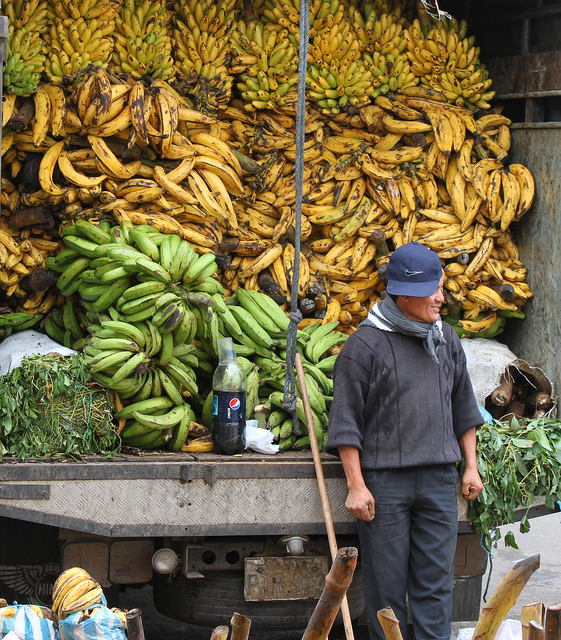

In [207]:
display(Image(data=img.value))

In [183]:
single.keys()

[b'/dataset/coco/2017/image/416337/info']

In [ ]:
@redgrease.trigger(on=single)
def my_command(arg1, arg2):
    redgrease.log(f"Doing it with {arg1} and {arg2}")
    return 42

my_command()


In [ ]:
single.gears.trigger("DOEIT", "Blah", 213)